# Diabetes Diagnosis Pipeline: KNN, SVM, RF, and ANFIS
This notebook implements a full pipeline for diabetes diagnosis using classical ML (KNN, SVM, RF) and ANFIS.

## 1. Install requirements

In [ ]:
!pip install scikit-learn pandas matplotlib joblib sanfis

## 2. Folder preparation & imports

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import joblib


## 3. Data loading and preprocessing

In [14]:
# Load dataset
df = pd.read_csv("diabetes.csv")

# Replace zeros in certain columns with column mean (as in medical ML best practice)
zero_fill_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for col in zero_fill_cols:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].mean())

# Remove common outliers (can adjust according to your project)
df = df[(df['BMI'] <= 67) & (df['Insulin'] <= 846)]

# Feature selection (according to your paper/R pipeline)
features = ["Pregnancies", "Glucose", "BMI", "DiabetesPedigreeFunction"]
X = df[features].values
y = df["Outcome"].values

# Standardization
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.3, random_state=42, stratify=y
)


# Convert for PyTorch
# Ensure y_train_torch, y_test_torch are float and values are strictly 0.0 or 1.0
y_train_torch = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
y_train_torch = torch.clamp(y_train_torch, 0.0, 1.0)
y_test_torch = torch.clamp(y_test_torch, 0.0, 1.0)


## 4. Classical ML model training & export (KNN, SVM, RF)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# KNN
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_prob = knn.predict_proba(X_test)[:,1]
joblib.dump(knn, "model/knn_model.pkl")

# SVM
svm = SVC(kernel='rbf', C=1, gamma='auto', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_prob = svm.predict_proba(X_test)[:,1]
joblib.dump(svm, "model/svm_model.pkl")

# Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)[:,1]
joblib.dump(rf, "model/rf_model.pkl")


## 5. S-ANFIS model (PyTorch) training & export

In [ ]:
from numpy import linspace

# Example: 7 MFs, mixed type, train 200 epochs, AdamW + 更小 lr
MEMBFUNCS = [
    {'function': 'gaussian', 'n_memb': 7,
     'params': {'mu': {'value': linspace(-1, 1, 7).tolist(), 'trainable': True},
                'sigma': {'value': [0.8]*7, 'trainable': True}}},
    {'function': 'bell', 'n_memb': 7,
     'params': {'c': {'value': linspace(-1, 1, 7).tolist(), 'trainable': True},
                'a': {'value': [2.0]*7, 'trainable': False},
                'b': {'value': [3.0]*7, 'trainable': False}}},
    {'function': 'gaussian', 'n_memb': 7,
     'params': {'mu': {'value': linspace(-1, 1, 7).tolist(), 'trainable': True},
                'sigma': {'value': [0.8]*7, 'trainable': True}}},
    {'function': 'sigmoid', 'n_memb': 7,
     'params': {'c': {'value': linspace(-1, 1, 7).tolist(), 'trainable': True},
                'gamma': {'value': [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0], 'trainable': True}}}
]

model = SANFIS(membfuncs=MEMBFUNCS, n_input=4, scale='Std')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
loss_fn = torch.nn.MSELoss(reduction='mean')
history = model.fit(train_data=[X_train_torch, y_train_torch],
                    valid_data=[X_test_torch, y_test_torch],
                    optimizer=optimizer,
                    loss_function=loss_fn,
                    epochs=1000)

y_pred_anfis = model.predict(X_test_torch).flatten().detach().numpy()
y_pred_anfis_binary = (y_pred_anfis > 0.5).astype(int)

# Save model
torch.save(model.state_dict(), 'model/anfis_model.pt')

## 6. Model evaluation & performance visualization

,Accuracy,F1 Score,AUC
Model,,,
KNN,0.709957,0.544218,0.786051
SVM,0.722944,0.522388,0.769992
RF,0.744589,0.593103,0.814735
ANFIS,0.757576,0.605634,0.826821


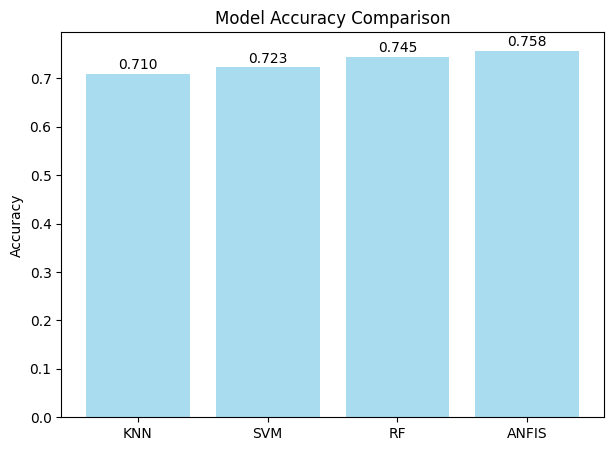

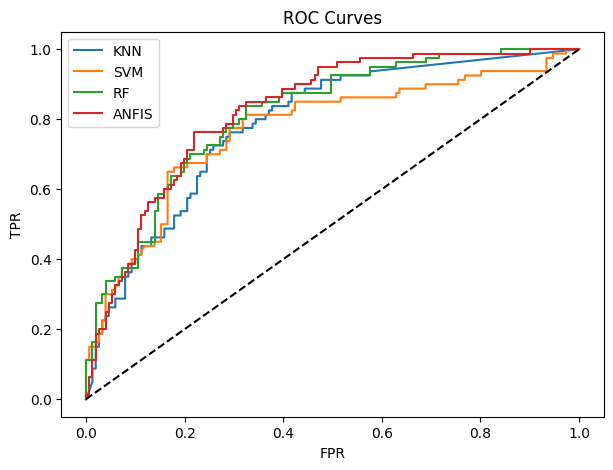

In [30]:
# 6. Evaluation and visualization

models = ["KNN", "SVM", "RF", "ANFIS"]
accs = [
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_anfis_binary),
]
f1s = [
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_svm),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_anfis_binary),
]
aucs = [
    roc_auc_score(y_test, knn_prob),
    roc_auc_score(y_test, svm_prob),
    roc_auc_score(y_test, rf_prob),
    roc_auc_score(y_test, y_pred_anfis),
]

df_results = pd.DataFrame({
    "Model": models,
    "Accuracy": accs,
    "F1 Score": f1s,
    "AUC": aucs
}).set_index("Model")
display(df_results)

# Save F1/Accuracy/AUC summary table as a PNG image

def save_table_as_image(df, path="comparison/f1_auc_table.png"):
    import matplotlib.pyplot as plt
    import numpy as np
    fig, ax = plt.subplots(figsize=(7, 2))
    ax.axis('off')
    tbl = ax.table(
        cellText=np.round(df.values, 3),
        colLabels=df.columns,
        rowLabels=df.index,
        loc='center',
        cellLoc='center',
        colLoc='center'
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    tbl.scale(1.2, 1.5)
    plt.title("Summary Table: Accuracy, F1 Score, AUC", fontsize=14)
    plt.savefig(path, bbox_inches='tight')
    plt.close()

save_table_as_image(df_results, path="comparison/f1_auc_table.png")


# Accuracy bar plot
plt.figure(figsize=(7,5))
plt.bar(models, accs, color='skyblue', alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for i, v in enumerate(accs):
    plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.savefig("comparison/accuracy_comparison.png")
plt.show()

# ROC curves
from sklearn.metrics import roc_curve
plt.figure(figsize=(7,5))
for name, prob in zip(models, [knn_prob, svm_prob, rf_prob, y_pred_anfis]):
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1],'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves")
plt.legend()
plt.savefig("comparison/auc_curves.png")
plt.show()